# Importar librerias y data

In [1]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 5.5 MB/s eta 0:00:00


In [2]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.2 MB/s eta 0:00:00


In [3]:
!pip install translate

In [4]:
!pip install translate langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=9783c8728536c73ac6e690645a0028c2c4ef5a35f7db709d5a3731972fd34386
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [5]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.9 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=d76dd707ff4752f208c1d6c49a1c433695a11e4c54034592fc9575a4e0af1b36
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [6]:
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.corpus import wordnet
import spacy
import gensim
from gensim.parsing.preprocessing import remove_stopwords

import emoji
import demoji
from translate import Translator
from langdetect import detect, LangDetectException

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sentence_transformers import SentenceTransformer

In [7]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [8]:
demoji.download_codes()
nlp = spacy.load('en_core_web_sm')

<ipython-input-8-16a0a91e57ae>:1: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [9]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/union-total/reviews.csv", sep="|")

In [10]:
df.head(2)

,date,rating,review,user_id,place_id
0,2005-07-24,5.0,This is totallly one of the best hotels in the...,n-lBS02-3yvlY5Q91mmwDA,3NdRfVpi3-tfk9vdiJ_F7w
1,2008-12-29,5.0,Recently stayed here over the holidays and was...,CNUOd9Xd8jmXrsioD1vwCg,3NdRfVpi3-tfk9vdiJ_F7w


In [11]:
df.drop(columns=["date", "user_id", "place_id"], inplace=True)

# Etiquetado y Scores

In [12]:
def sentiment_score(score, lim_pos, lim_neg):
  if score > lim_pos:
    return 2 # positivo
  elif score < lim_neg:
    return 0 # negativo
  else:
    return 1 # neutral

En TextBlob, Polarity oscila entre -1 y 1, siendo -1 un comentario  muy negativo y 1 uno muy positivo. Mientras que subjectivity cercano estre en 0 y 1, donde 0 es algo objetivo y 1 algo subjetivo.

In [13]:
def score_textblob(review):
    blob = TextBlob(review)
    sentiment = blob.sentiment
    return sentiment.polarity

Vader se puede usar independiente o mediante un modulo de NLTK. Compound es la suma entre los puntajes negativos, positivos y neutros y se normaliza para que sea un resultado entre -1 y 1, siendo -1 muy negativo y 1 muy positivo.

In [14]:
analyzer = SentimentIntensityAnalyzer()
def score_vader(review):
  scores = analyzer.polarity_scores(review)
  return scores

In [15]:
df["sentiment_rating"] = [sentiment_score(x, 3, 3) for x in df["rating"]]

In [16]:
df

,rating,review,sentiment_rating
0,5.0,This is totallly one of the best hotels in the...,2
1,5.0,Recently stayed here over the holidays and was...,2
2,4.0,I was pretty pleased with the hotel. The locat...,2
3,5.0,We stayed here during Essence last year and it...,2
4,5.0,This place is absolutely gorgeous. I got an am...,2
...,...,...,...
30781,1.0,So this is how I would break this hotel down\n...,0
30782,4.0,visit/stay: may 28-31st\n\nso the thing with r...,2
30783,1.0,"We were in a basement room, which I wouldn’t c...",0
30784,1.0,Extremely shabby and unclean rooms! The staff ...,0


In [17]:
df.groupby("sentiment_rating").agg("count")

,rating,review
sentiment_rating,,
0,9906,9906
1,3446,3446
2,17434,17434


# Sin preprocesado

In [ ]:
df_sin = df.copy()

In [ ]:
# 21 segundos
df_sin["score_textblob"] = [score_textblob(x) for x in df_sin["review"]]

In [ ]:
df_sin["sentiment_textblob"] = [sentiment_score(x, 0.05, -0.05) for x in df_sin["score_textblob"]]

In [ ]:
# 32 segundos
res = {}
for i in range(len(df_sin)):
    result = score_vader(df_sin["review"][i])
    res[i] = result

vader = pd.DataFrame(res).T

In [ ]:
vader = vader.reset_index()
df_sin = df_sin.reset_index()
df_sin_merged = df_sin.merge(vader, how="left")

In [ ]:
df_sin_merged["sentiment_vader"] = [sentiment_score(x, 0.05, -0.05) for x in df_sin_merged["compound"]]

In [ ]:
df_sin_merged.head(2)

,index,rating,review,sentiment_rating,score_textblob,sentiment_textblob,neg,neu,pos,compound,sentiment_vader
0,0,5.0,This is totallly one of the best hotels in the...,2,0.100000,2,0.000,0.780,0.220,0.7753,2
1,1,5.0,Recently stayed here over the holidays and was...,2,0.440265,2,0.016,0.805,0.179,0.9600,2


In [ ]:
accuracy_textblob = accuracy_score(df_sin_merged['sentiment_rating'], df_sin_merged['sentiment_textblob'])
accuracy_vader = accuracy_score(df_sin_merged['sentiment_rating'], df_sin_merged['sentiment_vader'])

In [ ]:
# 0.6679659585525889
accuracy_textblob

0.6679659585525889

In [ ]:
# 0.7170142272461508
accuracy_vader

0.7170142272461508

In [ ]:
confusion_textblob = confusion_matrix(df_sin_merged['sentiment_rating'], df_sin_merged['sentiment_textblob'])
confusion_vader = confusion_matrix(df_sin_merged['sentiment_rating'], df_sin_merged['sentiment_textblob'])

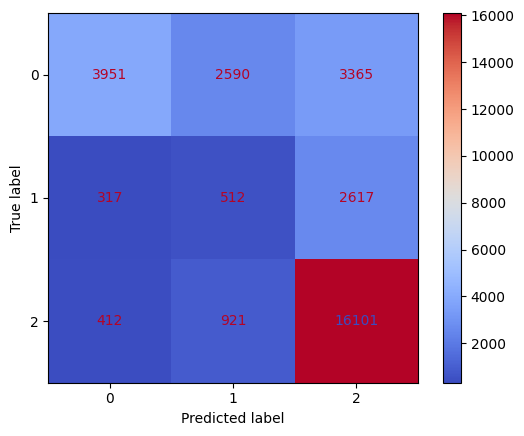

In [ ]:
disp = ConfusionMatrixDisplay(confusion_textblob)
disp.plot(cmap='coolwarm')
plt.show()

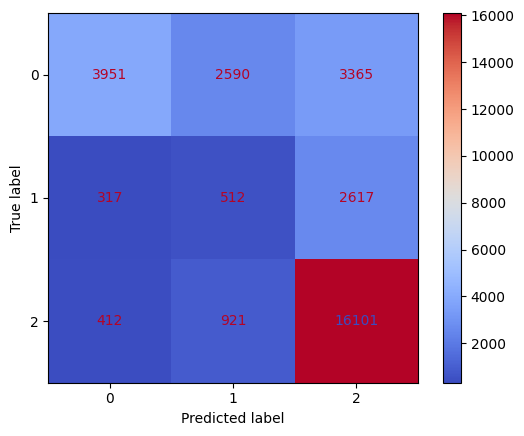

In [ ]:
disp = ConfusionMatrixDisplay(confusion_vader)
disp.plot(cmap='coolwarm')
plt.show()

In [ ]:
df_sin_merged.drop(columns=["index"]).to_csv("/content/drive/MyDrive/Colab Notebooks/modelo_csv/df_sin_procesar.csv", sep="|", index=False)

# Emojis y Otros caracteres

In [ ]:
df.head(2)

,rating,review
0,5.0,This is totallly one of the best hotels in the...
1,5.0,Recently stayed here over the holidays and was...


In [18]:
import emoji

text_with_emojis = "👍😤🥵😉 Hello, how are you? 🚫😇😏👋"

def translate_emojis(text):
    translated_text = emoji.demojize(text)
    return translated_text
translated_text = translate_emojis(text_with_emojis)

print("Original Text:", text_with_emojis)
print("Translated Text:", translated_text)


Original Text: 👍😤🥵😉 Hello, how are you? 🚫😇😏👋
Translated Text: :thumbs_up::face_with_steam_from_nose::hot_face::winking_face: Hello, how are you? :prohibited::smiling_face_with_halo::smirking_face::waving_hand:


In [ ]:
print(score_textblob("happy face"))
print(score_vader("happy_face"))
print(score_textblob("thumbs up"))
print(score_vader("ok"))
print(score_vader("fuming"))

0.8
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
0.0
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.296}
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5719}


Estas librerias no leen algunos emojis traducidos ni en su estado normal, entonces hay que reemplazarlos

In [19]:
def translate_emojis(text):
    return demoji.replace_with_desc(text, ' ')

In [ ]:
translate_emojis("👍😤🥵😉 Hello, how are you? 🚫😇😏👋")

' thumbs up  face with steam from nose  hot face  winking face  Hello, how are you?  prohibited  smiling face with halo  smirking face  waving hand '

In [ ]:
# 2 min

import demoji

# el conjunto de emojis para su análisis
demoji.download_codes()

unique_emojis = set()
for text in df['review']:
    emojis = demoji.findall(text)
    unique_emojis.update(emojis.keys())

<ipython-input-106-c43733ac4977>:4: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [ ]:
array_emojis = np.array(unique_emojis)
array_emojis

array({'💧', '👏', '🖕🏼', '🚴', '😨', '✈️', '👎🏿', '👊🏼', '🤷', '😵\u200d💫', '😗', '✔', '🚫', '😎', '🐔', '👏🏽', '😸', '☹', '👀', '🐸', '😤', '😂', '🤦🏿', '🦚', '🎪', '🤓', '🐬', '🐕', '😮', '⭐', '😛', '😓', '💗', '🍍', '💊', '🥳', '✌🏿', '❤️', '🤷🏼\u200d♂️', '😠', '🚭', '🧽', '🌴', '🎈', '🤩', '💞', '👎🏾', '🍹', '🤮', '📸', '✨', '🌙', '💯', '🧡', '🥵', '🏨', '😖', '🇮🇶', '🐶', '🔒', '😐', '👌🏼', '🍻', '🤦🏻\u200d♂️', '👟', '🙏', '🍊', '➕', '😔', '😦', '😊', '🙌🏻', '😃', '💰', '🍞', '👏🏻', '🤕', '💋', '🗿', '🥂', '🙁', '🎇', '💓', '🌹', '🪳', '🌠', '🦜', '🌅', '😑', '🇨🇦', '‼', '❣', '🎁', '🥴', '🤔', '🏡', '☺️', '🚪', '🤷🏻\u200d♀️', '🏊\u200d♀️', '😱', '🚕', '©', '👍🏽', '💿', '⚾', '🆗', '❗', '😪', '💡', '😋', '🤷🏼', '😇', '🚿', '🌞', '🍔', '♥️', '🦢', '🤬', '⬇️', '🥃', '💙', '😞', '🗽', '💝', '💖', '🤑', '🎰', '🙏🏻', '🍩', '🗑', '😻', '😀', '😏', '☀️', '😕', '💘', '😍', '🍟', '™', '🦅', '🤨', '☕', '🤘', '😳', '👌', '🍷', '🔌', '⛳', '🙄', '🤢', '🤷🏾\u200d♀️', '🔑', '🙃', '🧼', '😬', '👎', '👌🏾', '🤷\u200d♀️', '😒', '😷', '🎯', '🧇', '👁️', '🎉', '🤦🏼\u200d♂️', '👍', '😆', '🐛', '✅', '👎🏼', '👍🏾', '🔥', '✌🏼', '🕉', '🍆', '🤗', '💚', '😭', '💪🏾'

In [20]:
emoji_to_word = {
    '😀': 'happy', "😊": "happy", "😎": "happy", "😆": "happy", "😜": "happy", "😌": "happy", "🤩": "happy",
    "😋": "happy", "🤓": "happy",
    '😢': 'sad',  "🙁": "sad", "😪": "sad", "😔": "sad", "😓": "sad", "😓": "sad", "☹": "sad",
    '😍': 'love', "💚": "love", "💜": "love", "❤": "love", "❤": "love", "💕": "love", "💛": "love",
    "💙": "love", "💞": "love", "❤️": "love", "💖": "love",
    "👍": "good",
    "😗": "kiss", "😘": "kiss", "💋": "kiss",
    "😱": "scary", "😨": "scary",
    "😏": "smile",
    "😤": "fuming",
    "😫": "tired",
    "🤬": "angry", "😡": "angry", "🖕🏼": "angry",
    "🚫": "no", "⛔": "no", "❌": "no",
    "✌🏼": "peace",
    "😇": "innocent",
    "🤦": "embarrass", "😳": "embarrass",
    "😮": "surprise",
    "👎🏽": "bad", "👎🏾": "bad", "👎🏼": "bad",
    "💪🏾": "strong", "💪": "strong",
    "🤮": "disgusting", "😖": "disgusting",
    "🤨": "confused",
    "👌": "ok", "👌🏼": "ok",
}


In [ ]:
text = """(Translated by Google) Solo trip in May. Very attentive employees. I Can't complain. Clean, comfortable, big rooms! Air conditioning and excellent safe. Very nice and clean bathroom. Very good location.
Full breakfast, water dispenser and coffee all day.
I recommend it in price and quality! 😀💚

(Original)
Viaje sola en Mayo. Empleados muy atentos. Habitaciones limpias, cómodas, grandes! Aire acondicionado y caja fuerte excelente. Baño muy lindo y limpio. Muy buena ubicación.
Desayuno completo, dispenser de agua y cafe todo el día.
Lo recomiendo en precio y calidad!"""

# Traducción

In [ ]:
# 3 min
def detect_language(text):
    try:
        language = detect(text)
        return language
    except LangDetectException:
        return "no detectado"

df['language'] = df['review'].apply(detect_language)


In [ ]:
df[df["language"] == "no detectado"]

,rating,review,language
6900,5.000000,_,no detectado
10319,5.000000,👏🏽👏🏽,no detectado
10794,5.000000,💕💟💖💗👏👍,no detectado
11157,1.000000,👎🏼,no detectado
11545,2.000000,👍,no detectado
11815,5.000000,[,no detectado
13135,4.000000,👍👍😉,no detectado
14936,5.000000,😊💪🤘👊,no detectado
14938,5.000000,👍,no detectado
14947,5.000000,👌👌,no detectado


In [ ]:
def translator(text):
  # Detect the source language
  source_language = detect_language(text)
  if source_language == "no detectado":
    return text
  elif source_language == "en":
    return text
  else:
    # Create a translator instance
    translator = Translator(to_lang="en", from_lang = source_language)

    # Translate the text to English
    traduccion = translator.translate(text)

  return traduccion

In [ ]:
translator("")

''

In [ ]:
translator(df_sin_merged["review"][599])

'The hotel is not bad, clean, rooms are huge. Shuttle bus to the center, but you can also walk.\nBreakfast is ok, nothing more...'

In [21]:
def cleaning_text(text):
  for emoji, word in emoji_to_word.items():
    text = text.replace(emoji, word + " ")

  text = translate_emojis(text)

  keyword = "(Original)"

  # Encontrar la posición de la palabra clave
  keyword_index = text.find(keyword)

  # Eliminar todo después de la palabra clave
  if keyword_index != -1:
      text = text[:keyword_index + len(keyword)]

  text = text.replace("(Translated by Google)", "")
  text = text.replace("(Original)", "")
  text = text.replace("\n", " ")
  # text = translator(text)
  text = re.sub(r'[^\w\s]', '', text)
  text = text.strip()
  text = text.lower()
  if not text:
    return None
  return text

In [22]:
cleaning_text("👍😤🥵😉 Hello, how are you? 🚫😇😏👋")

'good fuming  hot face  winking face  hello how are you no innocent smile  waving hand'

In [23]:
clean_text = cleaning_text("")
clean_text

''

In [ ]:
clean_text = cleaning_text(df_sin_merged["review"][430])
clean_text

'Fabulous Boutique cottage rooms  gracious gardens  gourmet dining  charming'

In [ ]:
# 31 min
df["cleaned_text"] = [cleaning_text(x) for x in df["review"]]

In [ ]:
df.head(2)

,rating,review,language,cleaned_text
0,5.0,This is totallly one of the best hotels in the...,en,This is totallly one of the best hotels in the...
1,5.0,Recently stayed here over the holidays and was...,en,Recently stayed here over the holidays and was...


In [ ]:
df["sentiment_rating"] = [sentiment_score(x, 3, 3) for x in df["rating"]]

In [ ]:
df.drop(columns="language").to_csv("/content/drive/MyDrive/Colab Notebooks/modelo_csv/df_cleaned_text.csv", sep="|", index=False)

In [ ]:
df["score_textblob"] = [score_textblob(x) for x in df["cleaned_text"]]
df["sentiment_textblob"] = [sentiment_score(x, 0.05, -0.05) for x in df["score_textblob"]]

In [ ]:
res = {}
for i in range(len(df)):
  result = score_vader(df["cleaned_text"][i])
  res[i] = result

vader = pd.DataFrame(res).T
vader = vader.reset_index()
df = df.reset_index()
df_merged = df.merge(vader, how="left")

In [ ]:
df_merged["sentiment_vader"] = [sentiment_score(x, 0.05, -0.05) for x in df_merged["compound"]]
df_merged["sentiment_rating"] = [sentiment_score(x, 3, 3) for x in df_merged["rating"]]

In [ ]:
accuracy_textblob_clean = accuracy_score(df_merged['sentiment_rating'], df_merged['sentiment_textblob'])
accuracy_vader_clean = accuracy_score(df_merged['sentiment_rating'], df_merged['sentiment_vader'])

In [ ]:
# 0.6679659585525889
accuracy_textblob_clean

0.6679659585525889

In [ ]:
# 0.7197752225037355
accuracy_vader_clean

0.7197752225037355

In [ ]:
confusion_textblob_clean = confusion_matrix(df_merged['sentiment_rating'], df_merged['sentiment_textblob'])
confusion_vader_clean = confusion_matrix(df_merged['sentiment_rating'], df_merged['sentiment_vader'])

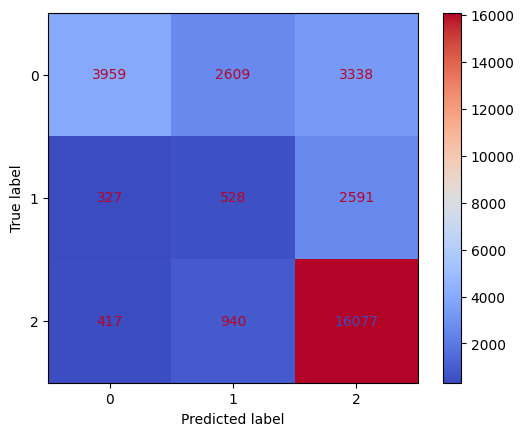

In [ ]:
disp = ConfusionMatrixDisplay(confusion_textblob_clean)
disp.plot(cmap='coolwarm')
plt.show()

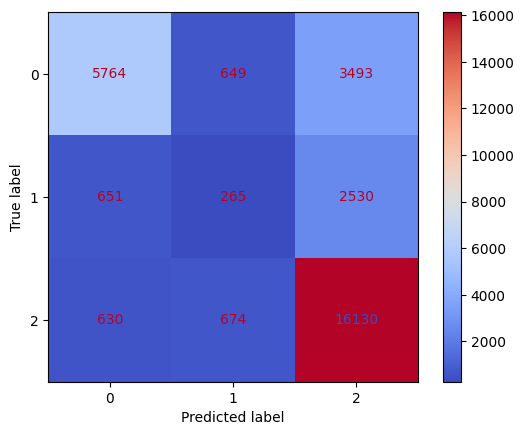

In [ ]:
disp = ConfusionMatrixDisplay(confusion_vader_clean)
disp.plot(cmap='coolwarm')
plt.show()

# Stopwords

In [ ]:
df_stop = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/modelo_csv/df_cleaned_text.csv", sep="|")
df_stop.head(2)

,index,rating,review,cleaned_text,score_textblob,sentiment_textblob,sentiment_rating
0,0,5.0,This is totallly one of the best hotels in the...,This is totallly one of the best hotels in the...,0.10000,2.0,2.0
1,1,5.0,Recently stayed here over the holidays and was...,Recently stayed here over the holidays and was...,0.43582,2.0,2.0


In [ ]:
df_stop.isna().sum()

index                 0
rating                0
review                0
cleaned_text          3
score_textblob        2
sentiment_textblob    2
sentiment_rating      2
dtype: int64

In [ ]:
df_stop["cleaned_text"].fillna("emoji", inplace=True)

In [ ]:
def remove_stopwords(text, stopwords_list):
  tokens = word_tokenize(text)
  filtered_sentence = []
  for i in tokens:
    if i not in stopwords_list:
        filtered_sentence.append(i)

  return " ".join(filtered_sentence)

### NLTK

In [ ]:
stopwords_nltk = stopwords.words('english')

In [ ]:
remove_stopwords(clean_text, stopwords_nltk)

''

### Spacy

In [ ]:
sp = spacy.load("en_core_web_sm")
spacy_stopwords = sp.Defaults.stop_words

In [ ]:
remove_stopwords(clean_text, spacy_stopwords)

'Solo trip May Very attentive employees I Cant complain Clean comfortable big rooms Air conditioning excellent safe Very nice clean bathroom Very good location Full breakfast water dispenser coffee day I recommend price quality happy love'

### Gensim

In [ ]:
remove_stopwords(clean_text, gensim.parsing.preprocessing.STOPWORDS)

'Solo trip May Very attentive employees I Cant complain Clean comfortable big rooms Air conditioning excellent safe Very nice clean bathroom Very good location Full breakfast water dispenser coffee day I recommend price quality happy love'

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords

result = remove_stopwords(clean_text)
result

'Solo trip May Very attentive employees I Cant complain Clean comfortable big rooms Air conditioning excellent safe Very nice clean bathroom Very good location Full breakfast water dispenser coffee day I recommend price quality happy love'

### Sklearn

In [ ]:
remove_stopwords(clean_text, ENGLISH_STOP_WORDS)

'Solo trip May Very attentive employees I Cant complain Clean comfortable big rooms Air conditioning excellent safe Very nice clean bathroom Very good location Full breakfast water dispenser coffee day I recommend price quality happy love'

In [ ]:
df_stop["no_stopwords"] = [remove_stopwords(x,  spacy_stopwords) for x in df_stop["cleaned_text"]]

In [ ]:
df_stop.head(2)

,index,rating,review,cleaned_text,score_textblob,sentiment_textblob,sentiment_rating,no_stopwords
0,0,5.0,This is totallly one of the best hotels in the...,This is totallly one of the best hotels in the...,0.10000,2.0,2.0,This totallly best hotels city The rooms heavi...
1,1,5.0,Recently stayed here over the holidays and was...,Recently stayed here over the holidays and was...,0.43582,2.0,2.0,Recently stayed holidays impressed fronts The ...


In [ ]:
df_stop.drop(columns=["index"]).to_csv("/content/drive/MyDrive/Colab Notebooks/modelo_csv/df_stop.csv", sep="|", index=False)

In [ ]:
df_stop["score_textblob"] = [score_textblob(x) for x in df_stop["no_stopwords"]]
df_stop["sentiment_textblob"] = [sentiment_score(x, 0.05, -0.05) for x in df_stop["score_textblob"]]

In [ ]:
res = {}
for i in range(len(df_stop)):
  result = score_vader(df_stop["no_stopwords"][i])
  res[i] = result

vader = pd.DataFrame(res).T
vader = vader.reset_index()
df_stop = df_stop.reset_index()
df_stop_merged = df_stop.merge(vader, how="left")

In [ ]:
df_stop_merged["sentiment_vader"] = [sentiment_score(x, 0.05, -0.05) for x in df_stop_merged["compound"]]

In [ ]:
df_stop_merged.dropna(inplace=True)

In [ ]:
accuracy_textblob_stop = accuracy_score(df_stop_merged['sentiment_rating'], df_stop_merged['sentiment_textblob'])
accuracy_vader_stop = accuracy_score(df_stop_merged['sentiment_rating'], df_stop_merged['sentiment_vader'])

In [ ]:
# nltk 0.6662984861282568
# spacy 0.6734130335910598
# Sklearn 0.6716262750958353
# Gensim 0.67230849197583
accuracy_textblob_stop

0.6732174760435277

In [ ]:
# nltk 0.6950165681242284
# spacy 0.6959883059931785
# Sklearn 0.6947241894613735
# Gensim 0.6950490546423235
accuracy_vader_stop

0.6959883059931785

# Lemmatizacion

In [ ]:
def lemmatize(text):
  doc = nlp(text)
  tokens = []
  for token in doc:
      tokens.append(token)
  lemmatization = [token.lemma_ for token in doc]
  sentence = " ".join(lemmatization)
  return sentence

In [ ]:
lemmatize(clean_text)

'solo trip in May very attentive employee I can not complain clean comfortable big room air conditioning and excellent safe very nice and clean bathroom very good location full breakfast water dispenser and coffee all day I recommend it in price and quality happy love'

In [ ]:
df_stop.drop(columns=["index"], inplace=True)

In [ ]:
# 10 min
df_stop["lemmatized"] = [lemmatize(x) for x in df_stop["cleaned_text"]]

In [ ]:
df_stop.head(2)

,rating,review,cleaned_text,score_textblob,sentiment_textblob,sentiment_rating,no_stopwords,lemmatized
0,5.0,This is totallly one of the best hotels in the...,This is totallly one of the best hotels in the...,0.100000,2,2.0,This totallly best hotels city The rooms heavi...,this be totallly one of the good hotel in the ...
1,5.0,Recently stayed here over the holidays and was...,Recently stayed here over the holidays and was...,0.423598,2,2.0,Recently stayed holidays impressed fronts The ...,recently stay here over the holiday and be imp...


In [ ]:
df_stop.drop(columns=["score_textblob", "sentiment_textblob"]).to_csv("/content/drive/MyDrive/Colab Notebooks/modelo_csv/df_lemma.csv", sep="|", index=False)

In [ ]:
df_stop["score_textblob"] = [score_textblob(x) for x in df_stop["lemmatized"]]
df_stop["sentiment_textblob"] = [sentiment_score(x, 0.05, -0.05) for x in df_stop["score_textblob"]]

In [ ]:
res = {}
for i in range(len(df_stop)):
  result = score_vader(df_stop["lemmatized"][i])
  res[i] = result

vader = pd.DataFrame(res).T
vader = vader.reset_index()
df_stop = df_stop.reset_index()
df_lemma = df_stop.merge(vader, how="left")

In [ ]:
df_lemma["sentiment_vader"] = [sentiment_score(x, 0.05, -0.05) for x in df_lemma["compound"]]

In [ ]:
df_lemma.dropna(inplace=True)

In [ ]:
accuracy_textblob_lemma = accuracy_score(df_lemma['sentiment_rating'], df_lemma['sentiment_textblob'])
accuracy_vader_lemma = accuracy_score(df_lemma['sentiment_rating'], df_lemma['sentiment_vader'])

In [ ]:
# 0.6655514049049862

accuracy_textblob_lemma

0.6655514049049862

In [ ]:
# 0.701445509176547

accuracy_vader_lemma

0.701445509176547

## Stemming

In [ ]:
df_lemma.drop(columns=["index"], inplace=True)

In [ ]:
def stem(text):
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = " ".join(stemmed_words)
    return stemmed_text

In [ ]:
stem(clean_text)

'solo trip in may veri attent employe i cant complain clean comfort big room air condit and excel safe veri nice and clean bathroom veri good locat full breakfast water dispens and coffe all day i recommend it in price and qualiti happi love'

In [ ]:
# 1 mim
df_lemma["stem"] = [stem(x) for x in df_lemma["cleaned_text"]]

In [ ]:
df_lemma.head(2)

,rating,review,cleaned_text,score_textblob,sentiment_textblob,sentiment_rating,no_stopwords,lemmatized,neg,neu,pos,compound,sentiment_vader,stem
0,5.0,This is totallly one of the best hotels in the...,This is totallly one of the best hotels in the...,-1.850372e-17,1,2.0,This totallly best hotels city The rooms heavi...,this be totallly one of the good hotel in the ...,0.00,0.821,0.179,0.6656,2,thi is totallli one of the best hotel in the c...
1,5.0,Recently stayed here over the holidays and was...,Recently stayed here over the holidays and was...,4.652976e-01,2,2.0,Recently stayed holidays impressed fronts The ...,recently stay here over the holiday and be imp...,0.04,0.775,0.185,0.9468,2,recent stay here over the holiday and wa impre...


In [ ]:
df_lemma.drop(columns=["score_textblob", "sentiment_textblob"]).to_csv("/content/drive/MyDrive/Colab Notebooks/modelo_csv/df_stem.csv", sep="|", index=False)

In [ ]:
df_lemma["score_textblob"] = [score_textblob(x) for x in df_lemma["stem"]]
df_lemma["sentiment_textblob"] = [sentiment_score(x, 0.05, -0.05) for x in df_lemma["score_textblob"]]

In [ ]:
df_lemma = df_lemma.reset_index(drop=True)

In [ ]:
res = {}
for i in range(len(df_lemma)):
  result = score_vader(df_lemma["stem"][i])
  res[i] = result

vader = pd.DataFrame(res).T
vader = vader.reset_index()
df_lemma = df_lemma.reset_index()
df_stem = df_lemma.merge(vader, how="left")

In [ ]:
df_stem.head(2)

,index,rating,review,cleaned_text,score_textblob,sentiment_textblob,sentiment_rating,no_stopwords,lemmatized,neg,neu,pos,compound,sentiment_vader,stem
0,0,5.0,This is totallly one of the best hotels in the...,This is totallly one of the best hotels in the...,0.25000,2,2.0,This totallly best hotels city The rooms heavi...,this be totallly one of the good hotel in the ...,0.00,0.821,0.179,0.6656,2,thi is totallli one of the best hotel in the c...
1,1,5.0,Recently stayed here over the holidays and was...,Recently stayed here over the holidays and was...,0.40873,2,2.0,Recently stayed holidays impressed fronts The ...,recently stay here over the holiday and be imp...,0.04,0.775,0.185,0.9468,2,recent stay here over the holiday and wa impre...


In [ ]:
df_stem["sentiment_vader"] = [sentiment_score(x, 0.05, -0.05) for x in df_stem["compound"]]

In [ ]:
accuracy_textblob_stem = accuracy_score(df_stem['sentiment_rating'], df_stem['sentiment_textblob'])
accuracy_vader_stem = accuracy_score(df_stem['sentiment_rating'], df_stem['sentiment_vader'])

In [ ]:
# 0.583206106870229
accuracy_textblob_stem

0.583206106870229

In [ ]:
# 0.701445509176547
accuracy_vader_stem

0.701445509176547

## Solo adjetivos

In [ ]:
df_transformado = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/modelo_csv/df_stem.csv", sep="|")

In [ ]:
df_transformado.shape

(30785, 12)

In [ ]:
df_transformado.head(2)

,rating,review,cleaned_text,sentiment_rating,no_stopwords,lemmatized,neg,neu,pos,compound,sentiment_vader,stem
0,5.0,This is totallly one of the best hotels in the...,This is totallly one of the best hotels in the...,2.0,This totallly best hotels city The rooms heavi...,this be totallly one of the good hotel in the ...,0.00,0.821,0.179,0.6656,2,thi is totallli one of the best hotel in the c...
1,5.0,Recently stayed here over the holidays and was...,Recently stayed here over the holidays and was...,2.0,Recently stayed holidays impressed fronts The ...,recently stay here over the holiday and be imp...,0.04,0.775,0.185,0.9468,2,recent stay here over the holiday and wa impre...


In [ ]:
def only_adjectives(review):
    doc = nlp(review)
    nouns = [token.text for token in doc if token.pos_ == 'ADJ']
    return ' '.join(nouns)

In [ ]:
# 6 min

df_transformado["solo_adjetivos"] = [only_adjectives(x) for x in df_transformado["cleaned_text"]]

In [ ]:
df_transformado["sentiment_rating"] = [sentiment_score(x, 3, 3) for x in df_transformado["rating"]]
df_transformado["score_textblob"] = [score_textblob(x) for x in df_transformado["solo_adjetivos"]]
df_transformado["sentiment_textblob"] = [sentiment_score(x, 0.1, -0.1) for x in df_transformado["score_textblob"]]

In [ ]:
res = {}
for i in range(len(df_transformado)):
  result = score_vader(df_transformado["solo_adjetivos"][i])
  res[i] = result

vader = pd.DataFrame(res).T
vader = vader.reset_index()
df_transformado = df_transformado.reset_index()
df_transformado_merged = df_transformado.merge(vader, how="left")

df_transformado_merged["sentiment_vader"] = [sentiment_score(x, 0.1, -0.1) for x in df_transformado_merged["compound"]]

In [ ]:
accuracy_textblob_con = accuracy_score(df_transformado_merged['rating_encoded'], df_transformado_merged['textblob_encoded'])
accuracy_vader_con = accuracy_score(df_transformado_merged['rating_encoded'], df_transformado_merged['vader_encoded'])

In [ ]:
# 0.6252680137742836

accuracy_textblob_con

0.6252680137742836

In [ ]:
# 0.6555779351569099

accuracy_vader_con

0.6555779351569099

In [ ]:
confusion_textblob_adj = confusion_matrix(df_transformado_merged['rating_encoded'], df_transformado_merged['textblob_encoded'])
confusion_vader_adj = confusion_matrix(df_transformado_merged['rating_encoded'], df_transformado_merged['vader_encoded'])

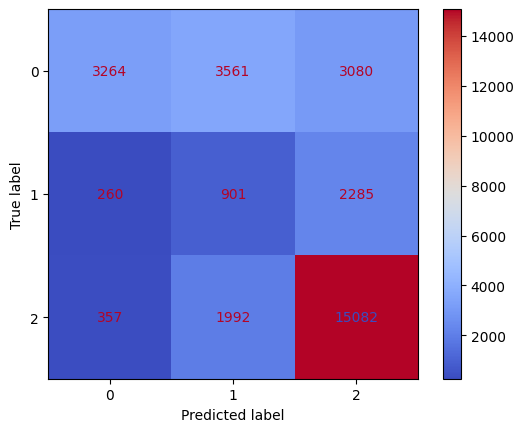

In [ ]:
disp = ConfusionMatrixDisplay(confusion_textblob_adj)
disp.plot(cmap='coolwarm')
plt.show()

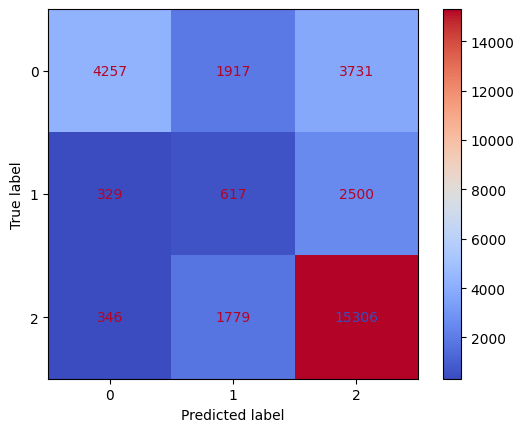

In [ ]:
disp = ConfusionMatrixDisplay(confusion_vader_adj)
disp.plot(cmap='coolwarm')
plt.show()

## Adjetivos, verbos y sustantivos

In [ ]:
def nouns_verbs_adjectives(review):
    doc = nlp(review)
    tokens_to_keep = [token.text for token in doc if token.pos_ in ['NOUN', 'VERB', 'ADJ']]
    return ' '.join(tokens_to_keep)

In [ ]:
# 5 min

df_transformado["sust_verb_adj"] = [nouns_verbs_adjectives(x) for x in df_transformado["cleaned_text"]]

In [ ]:
df_transformado["sentiment_rating"] = [sentiment_score(x, 3, 3) for x in df_transformado["rating"]]
df_transformado["score_textblob"] = [score_textblob(x) for x in df_transformado["sust_verb_adj"]]
df_transformado["sentiment_textblob"] = [sentiment_score(x, 0.1, -0.1) for x in df_transformado["score_textblob"]]

In [ ]:
res = {}
for i in range(len(df_transformado)):
  result = score_vader(df_transformado["sust_verb_adj"][i])
  res[i] = result

vader = pd.DataFrame(res).T
vader = vader.reset_index()
df_transformado = df_transformado.reset_index()
df_transformado_merged = df_transformado.merge(vader, how="left")

df_transformado_merged["sentiment_vader"] = [sentiment_score(x, 0.1, -0.1) for x in df_transformado_merged["compound"]]

In [ ]:
accuracy_textblob_con = accuracy_score(df_transformado_merged['rating_encoded'], df_transformado_merged['textblob_encoded'])
accuracy_vader_con = accuracy_score(df_transformado_merged['rating_encoded'], df_transformado_merged['vader_encoded'])

In [ ]:
# 0.6357936456370606

accuracy_textblob_con

0.6357936456370606

In [ ]:
# 0.686375154310961

accuracy_vader_con

0.686375154310961